<a href="https://colab.research.google.com/github/omarsayed7/Satellite-Segmentation/blob/main/Data_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio && GDAL==3.2.2 && paddleseg && paddlepaddle
!pip install pyshp
#mount google drive
from google.colab import drive 
drive.mount("/content/drive/")

/bin/bash: paddleseg: command not found
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import math
import os, sys, subprocess
import numpy as np 
from osgeo import gdal, ogr
import matplotlib.pyplot as plt

In [3]:
 OLD_DATASET_PATH = 'drive/MyDrive/graduation-project/output 2019'
 NEW_DATASET_PATH = 'drive/MyDrive/graduation-project/output'
 OUTPUT = 'lab_all_values.tif'

In [4]:
os.listdir(NEW_DATASET_PATH)

['output2021.tfw',
 'output2021.tif',
 'output2021.tif.ovr',
 'output2021.tif.aux.xml',
 'Export_Output.prj',
 'Export_Output.dbf',
 'Export_Output.sbn',
 'Export_Output.sbx',
 'Export_Output.shx',
 'Export_Output.cpg',
 'Export_Output.shp',
 'Export_Output.shp.DESKTOP-164F5K8.9080.19096.sr.lock']

In [5]:
fn_ras = os.path.join(NEW_DATASET_PATH,'output2021.tif')
fn_vec = os.path.join(NEW_DATASET_PATH,'Export_Output.shp')

In [6]:
driver = ogr.GetDriverByName("ESRI Shapefile")
ras_ds = gdal.Open(fn_ras)
vec_ds = driver.Open(fn_vec, 1)

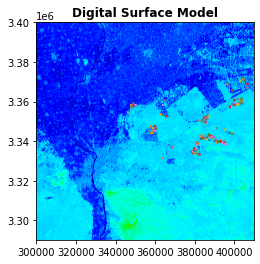

In [7]:
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show 

dsm = rasterio.open(fn_ras)
sf = shp.Reader(fn_vec)

plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
show(dsm, title='Digital Surface Model', cmap='gist_ncar')
plt.show()

In [8]:
lyr = vec_ds.GetLayer()
geot = ras_ds.GetGeoTransform()
proj = ras_ds.GetProjection() # Get the projection from original tiff (fn_ras)

In [9]:
#To get the coordinates of the corners of your geotiff do the following:
width = ras_ds.RasterXSize
height = ras_ds.RasterYSize

minx = geot[0] #lower left x
miny = geot[3] + width*geot[4] + height*geot[5] #lower left y
maxx = geot[0] + width*geot[1] + height*geot[2] #upper right x
maxy = geot[3] #upper right y

minx, miny, maxx, maxy

(300000.0, 3290220.0, 409800.0, 3400020.0)

In [10]:
#https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
import osr
# get CRS from dataset 
crs = osr.SpatialReference()
crs.ImportFromWkt(ras_ds.GetProjectionRef())
# create lat/long crs with WGS84 datum
crsGeo = osr.SpatialReference()
crsGeo.ImportFromEPSG(4326) # 4326 is the EPSG id of lat/long crs 
t = osr.CoordinateTransformation(crs, crsGeo)
(lat, long, z) = t.TransformPoint(minx, miny)
(lat2, long2, z2) = t.TransformPoint(maxx, maxy)
print(lat, long, z)
print(lat2, long2, z2)

30.932223205884945 29.72604902556356 0.0
32.057829637596484 30.729650251360194 0.0


In [11]:
!gdalinfo /content/drive/MyDrive/graduation-project/output/output2021.tif

Driver: GTiff/GeoTIFF
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining 

In [12]:
layerdefinition = lyr.GetLayerDefn()
feature = ogr.Feature(layerdefinition)

In [13]:
yy = feature.GetFieldIndex("MLDS")
if yy < 0:
    print("MLDS field not found, we will create one for you and make all values to 1")
else:
    lyr.DeleteField(yy)

MLDS field not found, we will create one for you and make all values to 1


In [14]:
new_field = ogr.FieldDefn("MLDS", ogr.OFTInteger)
lyr.CreateField(new_field)
for feature in lyr:
        feature.SetField("MLDS", 1)
        lyr.SetFeature(feature)
        feature = None

In [15]:
drv_tiff = gdal.GetDriverByName("GTiff")
chn_ras_ds = drv_tiff.Create(
        OUTPUT, ras_ds.RasterXSize, ras_ds.RasterYSize, 1, gdal.GDT_Byte)
print(chn_ras_ds)
chn_ras_ds.SetGeoTransform(geot)
chn_ras_ds.SetProjection(proj)
chn_ras_ds.FlushCache()

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa28f347c30> >


In [16]:
gdal.RasterizeLayer(chn_ras_ds, [1], lyr, burn_values=[1], options=["ATTRIBUTE=MLDS"])
chn_ras_ds = None
vec_ds = None

In [17]:
#Second - Splitting raster and rasterized files to small tiles 512×512 
#depends on your memory

In [18]:
ds = gdal.Open(fn_ras)
gt = ds.GetGeoTransform()

In [19]:
xmin = gt[0]
ymax = gt[3]
resx = gt[1]
res_y = gt[5]
resy = abs(res_y)

In [20]:
import math
import os.path as osp

In [21]:
needed_out_x = 512
needed_out_y = 512

In [22]:
xnotround = ds.RasterXSize / needed_out_x
xround = math.ceil(xnotround)
ynotround = ds.RasterYSize / needed_out_y
yround = math.ceil(ynotround)

print(xnotround)
print(xround)
print(ynotround)
print(yround)

10.72265625
11
10.72265625
11


In [23]:
pixtomX = needed_out_x * xround * resx
pixtomy = needed_out_y * yround * resy
print (pixtomX)
print (pixtomy)

112640.0
112640.0


In [24]:
#size of a single tile
xsize = pixtomX / xround
ysize = pixtomy / yround

print (xsize)
print (ysize)

10240.0
10240.0


In [25]:
#create lists of x and y coordinates
xsteps = [xmin + xsize * i for i in range(xround + 1)]
ysteps = [ymax - ysize * i for i in range(yround + 1)]
xsteps

[300000.0,
 310240.0,
 320480.0,
 330720.0,
 340960.0,
 351200.0,
 361440.0,
 371680.0,
 381920.0,
 392160.0,
 402400.0,
 412640.0]

In [27]:
#set the output path
cdpath = "DataSet"

In [ ]:
ds = gdal.Open(fn_ras)
gt = ds.GetGeoTransform()
c = 0 
for i in range(xround):
    for j in range(yround):
        xmin = xsteps[i]
        xmax = xsteps[i + 1]
        ymax = ysteps[j]
        ymin = ysteps[j + 1]
        # gdal translate to subset the input raster
        output_path = osp.join(cdpath,(str("01") + "-" + str(j) + "-" + str(i) + "." + "jpeg"))
        try:
            #com_string = "gdal_translate rgba.tif withmask.tif -srcwin " + str(j)+ ", " + str(i) + ", " + str(512) + ", " + str(512) + " " + str("drive/MyDrive/graduation-project/output/") + str("output2021.tif") + " " + str("Dataset/") + str("01") + str(i) + "_" + str(j) + ".jpeg"
            com_string = "gdal_translate -co TILED=YES -co COMPRESS=JPEG -co JPEG_QUALITY=100 -a_nodata none -co INTERLEAVE=BAND -scale -ot Byte" + " " + str("drive/MyDrive/graduation-project/output/") + str("output2021.tif") + " " +str("Dataset/") + str("01") + str(i) + "_" + str(j) + ".jpeg"
            os.system(com_string)
            # tt = gdal.Translate(output_path, 
            #         ds, 
            #         projWin=(abs(xmin), abs(ymax), abs(xmax), abs(ymin)),
            #         xRes=resx, 
            #         yRes=-resy, 
            #         outputType=gdal.GDT_Byte, 
            #         format="JPEG")
        except:
            print("Unexpected error color:", sys.exc_info(), gdal.GetLastErrorMsg())


In [42]:
os.listdir("Dataset")

['018_3.jpeg',
 '015_9.jpeg',
 '0110_6.jpeg',
 '012_0.jpeg',
 '014_0.jpeg',
 '013_1.jpeg',
 '012_3.jpeg',
 '017_6.jpeg',
 '019_5.jpeg',
 '013_3.jpeg',
 '013_10.jpeg',
 '010_2.jpeg',
 '019_4.jpeg',
 '011_10.jpeg',
 '013_2.jpeg',
 '011_5.jpeg',
 '012_2.jpeg',
 '010_7.jpeg',
 '015_10.jpeg',
 '019_10.jpeg',
 '012_1.jpeg',
 '0110_4.jpeg',
 '013_7.jpeg',
 '012_7.jpeg',
 '011_8.jpeg',
 '016_7.jpeg',
 '012_9.jpeg',
 '010_0.jpeg',
 '016_6.jpeg',
 '013_6.jpeg',
 '017_7.jpeg',
 '011_7.jpeg',
 '010_6.jpeg',
 '0110_10.jpeg',
 '016_4.jpeg',
 '014_9.jpeg',
 '0110_0.jpeg',
 '014_8.jpeg',
 '016_0.jpeg',
 '018_10.jpeg',
 '018_8.jpeg',
 '014_2.jpeg',
 '010_9.jpeg',
 '014_4.jpeg',
 '015_7.jpeg',
 '018_7.jpeg',
 '019_0.jpeg',
 '013_0.jpeg',
 '012_4.jpeg',
 '016_5.jpeg',
 '015_1.jpeg',
 '013_5.jpeg',
 '016_1.jpeg',
 '010_3.jpeg',
 '014_1.jpeg',
 '0110_9.jpeg',
 '010_4.jpeg',
 '015_2.jpeg',
 '011_1.jpeg',
 '017_9.jpeg',
 '016_8.jpeg',
 '017_2.jpeg',
 '016_2.jpeg',
 '017_8.jpeg',
 '0110_7.jpeg',
 '015_3.jpeg'

In [43]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('Dataset/018_0.jpeg')
imgplot = plt.imshow(img)
plt.show()

Populating the interactive namespace from numpy and matplotlib


UnidentifiedImageError: ignored